# Olympics Overall Medal Count
---
---
---

# ALL IMPORTS

In [26]:
# Import Pandas for dataframe functions
import pandas as pd

# Import Path from Pathlib to read csv's
from pathlib import Path

# The hvPlot library is a visualization library that’s designed to work with Pandas DataFrames
# use it to create interactive plots for our data
import hvplot.pandas

# Import numpy to fill an empty column with NAN values
import numpy as np

# Import Prophet from prophet to run a simulation on medal count
from fbprophet import Prophet

# Import Bokeh to display hvplots
from bokeh.plotting import figure

---
---

# Read in csv of Winter Olympics Medal Data

In [27]:
# Read in the data from the "all_winter_medals_locations.csv" file into a Pandas DataFrame
all_winter_medals_df=pd.read_csv(Path('Resources/all_winter_medals_locations_gsb.csv'))

# Review the resulting DataFrame
all_winter_medals_df

,Year,Sport,Event,Country,Medal Rank,Lat,Lon,Gold,Silver,Bronze
0,2002,Freestyle Skiing,Women's Aerials,Australia,1,-35.266667,149.133333,1.0,NaN,NaN
1,2002,Short-Track Speedskating,"Men's 1,000 Meters",Australia,1,-35.266667,149.133333,1.0,NaN,NaN
2,2006,Freestyle Skiing,Men's Moguls,Australia,1,-35.266667,149.133333,1.0,NaN,NaN
3,2010,Freestyle Skiing,Women's Aerials,Australia,1,-35.266667,149.133333,1.0,NaN,NaN
4,2010,Snowboarding,Women's Halfpipe,Australia,1,-35.266667,149.133333,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3164,1988,Luge,Men's Doubles,West Germany,3,50.737400,7.098200,NaN,NaN,1.0
3165,1984,Alpine Skiing,Men's Giant Slalom,Yugoslavia,2,43.850000,18.250000,NaN,1.0,NaN
3166,1988,Alpine Skiing,Women's Slalom,Yugoslavia,2,43.850000,18.250000,NaN,1.0,NaN
3167,1988,Ski Jumping,"Men's Large Hill, Team",Yugoslavia,2,43.850000,18.250000,NaN,1.0,NaN


## Prepare the Data

### Fill NA Values with zero

In [28]:
# Fill NA values with zero
all_winter_medals_df = all_winter_medals_df.fillna(0)

# Confirm changes to DataFrame
all_winter_medals_df

,Year,Sport,Event,Country,Medal Rank,Lat,Lon,Gold,Silver,Bronze
0,2002,Freestyle Skiing,Women's Aerials,Australia,1,-35.266667,149.133333,1.0,0.0,0.0
1,2002,Short-Track Speedskating,"Men's 1,000 Meters",Australia,1,-35.266667,149.133333,1.0,0.0,0.0
2,2006,Freestyle Skiing,Men's Moguls,Australia,1,-35.266667,149.133333,1.0,0.0,0.0
3,2010,Freestyle Skiing,Women's Aerials,Australia,1,-35.266667,149.133333,1.0,0.0,0.0
4,2010,Snowboarding,Women's Halfpipe,Australia,1,-35.266667,149.133333,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3164,1988,Luge,Men's Doubles,West Germany,3,50.737400,7.098200,0.0,0.0,1.0
3165,1984,Alpine Skiing,Men's Giant Slalom,Yugoslavia,2,43.850000,18.250000,0.0,1.0,0.0
3166,1988,Alpine Skiing,Women's Slalom,Yugoslavia,2,43.850000,18.250000,0.0,1.0,0.0
3167,1988,Ski Jumping,"Men's Large Hill, Team",Yugoslavia,2,43.850000,18.250000,0.0,1.0,0.0


### Add columns for cumulative returns of Gold, Silver, Bronze

In [29]:
# Group the original csv by 'Country' and sum the boolean Gold, Silver, Bronze columns
cum_df=all_winter_medals_df.groupby('Country').sum()[['Gold', 'Silver', 'Bronze']]

# Merge the dataframes
combined_cum_returns_df=all_winter_medals_df.merge(cum_df.reset_index(drop=False), on='Country')

# Confirm that cumulative returns columns for medal types were created as Medal_x and Medal_y
combined_cum_returns_df

,Year,Sport,Event,Country,Medal Rank,Lat,Lon,Gold_x,Silver_x,Bronze_x,Gold_y,Silver_y,Bronze_y
0,2002,Freestyle Skiing,Women's Aerials,Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0
1,2002,Short-Track Speedskating,"Men's 1,000 Meters",Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0
2,2006,Freestyle Skiing,Men's Moguls,Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0
3,2010,Freestyle Skiing,Women's Aerials,Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0
4,2010,Snowboarding,Women's Halfpipe,Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164,1988,Luge,Men's Doubles,West Germany,3,50.737400,7.098200,0.0,0.0,1.0,11.0,15.0,13.0
3165,1984,Alpine Skiing,Men's Giant Slalom,Yugoslavia,2,43.850000,18.250000,0.0,1.0,0.0,0.0,3.0,1.0
3166,1988,Alpine Skiing,Women's Slalom,Yugoslavia,2,43.850000,18.250000,0.0,1.0,0.0,0.0,3.0,1.0
3167,1988,Ski Jumping,"Men's Large Hill, Team",Yugoslavia,2,43.850000,18.250000,0.0,1.0,0.0,0.0,3.0,1.0


### Add column for total cumulative returns

In [30]:
# Sum the Medal_y cumulative returns and create a column of the output
combined_cum_returns_df['Total_y']=combined_cum_returns_df[['Gold_y', 'Silver_y', 'Bronze_y']].sum(axis=1)

# Confirm the creation of a Total_y column
combined_cum_returns_df

,Year,Sport,Event,Country,Medal Rank,Lat,Lon,Gold_x,Silver_x,Bronze_x,Gold_y,Silver_y,Bronze_y,Total_y
0,2002,Freestyle Skiing,Women's Aerials,Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0,15.0
1,2002,Short-Track Speedskating,"Men's 1,000 Meters",Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0,15.0
2,2006,Freestyle Skiing,Men's Moguls,Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0,15.0
3,2010,Freestyle Skiing,Women's Aerials,Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0,15.0
4,2010,Snowboarding,Women's Halfpipe,Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164,1988,Luge,Men's Doubles,West Germany,3,50.737400,7.098200,0.0,0.0,1.0,11.0,15.0,13.0,39.0
3165,1984,Alpine Skiing,Men's Giant Slalom,Yugoslavia,2,43.850000,18.250000,0.0,1.0,0.0,0.0,3.0,1.0,4.0
3166,1988,Alpine Skiing,Women's Slalom,Yugoslavia,2,43.850000,18.250000,0.0,1.0,0.0,0.0,3.0,1.0,4.0
3167,1988,Ski Jumping,"Men's Large Hill, Team",Yugoslavia,2,43.850000,18.250000,0.0,1.0,0.0,0.0,3.0,1.0,4.0


### Add a Boolean Total_x for "if medal = yes" and Fill NaN Values with 1, to be used as a boolean filter on hvplot function

In [31]:
# Use numpy to fill a column named 'Total_x' with NaN values
combined_cum_returns_df['Total_x'] = np.nan

# Fill NA values with 1
combined_cum_returns_df = combined_cum_returns_df.fillna(1)

# Confirm changes to DataFrame
combined_cum_returns_df


,Year,Sport,Event,Country,Medal Rank,Lat,Lon,Gold_x,Silver_x,Bronze_x,Gold_y,Silver_y,Bronze_y,Total_y,Total_x
0,2002,Freestyle Skiing,Women's Aerials,Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0,15.0,1.0
1,2002,Short-Track Speedskating,"Men's 1,000 Meters",Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0,15.0,1.0
2,2006,Freestyle Skiing,Men's Moguls,Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0,15.0,1.0
3,2010,Freestyle Skiing,Women's Aerials,Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0,15.0,1.0
4,2010,Snowboarding,Women's Halfpipe,Australia,1,-35.266667,149.133333,1.0,0.0,0.0,5.0,5.0,5.0,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164,1988,Luge,Men's Doubles,West Germany,3,50.737400,7.098200,0.0,0.0,1.0,11.0,15.0,13.0,39.0,1.0
3165,1984,Alpine Skiing,Men's Giant Slalom,Yugoslavia,2,43.850000,18.250000,0.0,1.0,0.0,0.0,3.0,1.0,4.0,1.0
3166,1988,Alpine Skiing,Women's Slalom,Yugoslavia,2,43.850000,18.250000,0.0,1.0,0.0,0.0,3.0,1.0,4.0,1.0
3167,1988,Ski Jumping,"Men's Large Hill, Team",Yugoslavia,2,43.850000,18.250000,0.0,1.0,0.0,0.0,3.0,1.0,4.0,1.0


---
---

# OVERALL MEDAL COUNT PREDICTION: 
## Plot an overlay trend of medals, grouped by country
---

### Prepare a DataFrame to be used in the HvPlot Trendline overlay

In [32]:
# Select the columns from the combined_cum_returns_df
trendline_plot_df = combined_cum_returns_df[['Country','Year','Gold_x', 'Silver_x', 'Bronze_x', 'Total_x']]

# Group the dataframe by Year and Country and perform the sum function
trend_plot_df = trendline_plot_df.groupby(['Year', 'Country']).sum()

# Confirm historical data columns have been created
trend_plot_df

Gold_x  Silver_x  Bronze_x  Total_x
Year Country                                           
1924 Austria           2.0       1.0       0.0      3.0
     Belgium           0.0       0.0       1.0      1.0
     Canada            1.0       0.0       0.0      1.0
     Finland           4.0       4.0       3.0     11.0
     France            0.0       0.0       3.0      3.0
...                    ...       ...       ...      ...
2018 Spain             0.0       0.0       2.0      2.0
     Sweden            7.0       6.0       1.0     14.0
     Switzerland       4.0       6.0       4.0     14.0
     Ukraine           1.0       0.0       0.0      1.0
     United States     9.0       8.0       6.0     23.0

[408 rows x 4 columns]

### Use HvPlot to create an overaly of GSBT trendlines

In [33]:
overlay_gsbt= trend_plot_df.hvplot(x='Year', y=['Gold_x', 'Silver_x', 'Bronze_x', 'Total_x'], groupby='Country', height=500, width=1200, value_label='Number of Medals')

overlay_gsbt

:DynamicMap   [Country]
   :NdOverlay   [Variable]
      :Curve   [Year]   (Number of Medals)

---
---

## Prophet Simulation
---


### Review trend_plot_df dataframe

In [34]:
trend_plot_df

Gold_x  Silver_x  Bronze_x  Total_x
Year Country                                           
1924 Austria           2.0       1.0       0.0      3.0
     Belgium           0.0       0.0       1.0      1.0
     Canada            1.0       0.0       0.0      1.0
     Finland           4.0       4.0       3.0     11.0
     France            0.0       0.0       3.0      3.0
...                    ...       ...       ...      ...
2018 Spain             0.0       0.0       2.0      2.0
     Sweden            7.0       6.0       1.0     14.0
     Switzerland       4.0       6.0       4.0     14.0
     Ukraine           1.0       0.0       0.0      1.0
     United States     9.0       8.0       6.0     23.0

[408 rows x 4 columns]

### Perform Prophet Simulations for 2022 Medal Count

In [35]:
# Clone the trend_plot_df into a new dataframe and reset the index
kl_df=trend_plot_df
kl_df=kl_df.reset_index()

# Select data from kl_df into a dataframe the Prophet dependency can read 
''' Here is where you input Medal_x into the function for GSBT predictions'''
all_countries_df=kl_df.pivot(index='Year', columns='Country', values='Gold_x').reset_index(drop=False)

all_countries_df.head()

# Clean the Year column into date time format
all_countries_df['Year']=pd.to_datetime(all_countries_df['Year'], format='%Y')

# Select the columns from the all_countries_df that will be used in the Prophet simulation
''' Here is where you input 'Country' into the function for GSBT predictions'''
one_df=all_countries_df[['Year', 'China']]
# Rename the columns so they are in syntax of the Prophet documentation
one_df.columns=['ds', 'y']

one_df.head()

# Fit the model by instantiating a new Prophet object
model=Prophet()
model.fit(one_df)

# Get a suitable dataframe that extends into the future a specified number of days
# Use 4*365 days from the 2018 data
future=model.make_future_dataframe(periods=1461)

# Use the predict method to assign each row in future a predicted value named yhat
forecast = model.predict(future)
# Display only the yhat prediction value for 1461 days from last value in 2018
forecast[['ds', 'yhat']].tail(1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


,ds,yhat
1483,2022-01-01,3.589605


### Plot the forecast

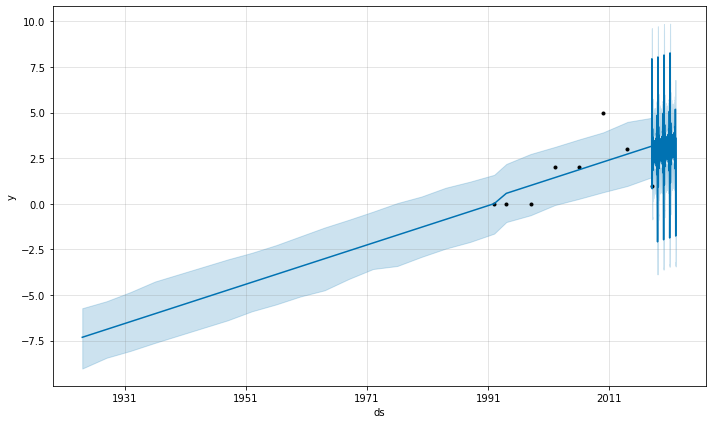

In [36]:
# Plot the forecast by calling the Prophet.plot method and passing in the forecast dataframe
fig1 = model.plot(forecast)

## Run the Simulation for each Medal_x and Country that we want to forecast
Prophet was run manually for each cell value and manually tabulated into a csv called 'beijing_total_medal_count_forecast.csv'

### Read in csv of Prophet forecast results

In [37]:
beijing_total_medal_count_forecast_df = pd.read_csv(Path('Resources/beijing_total_medal_count_forecast.csv'))
beijing_total_medal_count_forecast_df


,Country,Gold,Silver,Bronze,Total
0,Germany,13.304938,12.423865,8.468517,34.200475
1,United States,8.737703,8.930442,8.167370,25.873304
2,Norway,9.542529,8.494180,7.470627,25.586041
3,Canada,8.636452,7.711165,6.090819,22.464903
4,ROC,3.723646,7.287529,11.142462,22.269231
5,Austria,4.930853,5.561746,7.326002,17.864528
6,South Korea,5.162205,7.557807,3.423116,16.131148
7,Netherlands,5.998734,4.097720,5.313305,15.422468
8,Switzerland,4.610455,3.585948,3.956117,12.068417
9,Italy,3.282677,3.278728,5.432943,11.994356


---
---
# WORLD MAP OF MEDALS
---


### Create an all time count dataframe, to be used in the Streamlit Pydeck Geoplot

In [38]:
# Create an all time count dataframe, to be used in the Streamlit Pydeck Geoplot
all_time_count = combined_cum_returns_df[['Country', 'Lat', 'Lon', 'Gold_x', 'Silver_x', 'Bronze_x', 'Total_x']]
all_time_count = all_time_count.groupby(['Country']).sum()


## Create box plots which visualize the summary statistics of medal quality

###  Group by country and calculate mean of medal ranking

In [39]:
# Group the original dataframe by country and run a mean function on it to find mean value of medal rank
mean_medal_rank_by_country = all_winter_medals_df.groupby('Country').mean()

# Review the resulting DataFrame
mean_medal_rank_by_country.head()


,Year,Medal Rank,Lat,Lon,Gold,Silver,Bronze
Country,,,,,,,
Australia,2008.933333,2.000000,-35.266667,149.133333,0.333333,0.333333,0.333333
Austria,1986.025974,2.099567,48.200000,16.366667,0.277056,0.346320,0.376623
Belarus,2009.368421,1.842105,53.900000,27.566667,0.421053,0.315789,0.263158
Belgium,1949.200000,2.400000,50.833333,4.333333,0.200000,0.200000,0.600000
Bulgaria,1998.333333,2.333333,42.683333,23.316667,0.166667,0.333333,0.500000


In [40]:
summary_stats = mean_medal_rank_by_country.describe()
summary_stats

,Year,Medal Rank,Lat,Lon,Gold,Silver,Bronze
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,1992.922773,2.106923,44.777781,31.657627,0.286869,0.350346,0.362785
std,14.935123,0.330345,19.613721,50.803462,0.190526,0.199858,0.202823
min,1949.200000,1.000000,-41.300000,-77.036900,0.000000,0.000000,0.000000
25%,1983.395368,1.953671,43.266667,10.133333,0.183333,0.288018,0.283042
50%,1994.000000,2.064516,48.866667,18.050000,0.318182,0.333333,0.347826
75%,2005.931818,2.354167,52.433333,29.041667,0.365235,0.376123,0.500000
max,2013.000000,3.000000,60.166667,174.783333,1.000000,1.000000,1.000000


## Create a box plot of Mean Medal Rank

In [41]:
mean_medal_rank_by_country.hvplot.box(y=['Medal Rank'], height=300, width=600, legend=False, title='Mean Medal Rank with Gold=1, Silver=2, Bronze=3', invert=True)

:BoxWhisker   [Variable]   (value)

---
---

# Export Dataframes to csv to be used in Streamlit

In [42]:
# Export trend plot dataframe
# To be used in description for Overall medal count
trend_plot_df.to_csv('Resources/trend_plot.csv')

In [43]:
# Create an all time count dataframe, to be used in the Streamlit Pydeck Geoplot
all_time_count.to_csv('Resources/all_time_count_v1.csv')

In [44]:
# Export Summary Stats to csv
summary_stats.to_csv('Resources/medal_summary_stats.csv')

In [45]:
# Export Medal Quality dataframe for box plots
mean_medal_rank_by_country.to_csv('Resources/medal_quality.csv')